f


In [4]:
import sys
sys.path.append("..")


In [6]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

import tyxe
pyro.set_rng_seed(42)

# TyXe 
TyXe is a Bayesian neural network library build on top of Pytorch and Pyro which cleanlty separates the architecture, prior, inference and likelihood specification so that users can iterate quickly over different variations of these components. Moreover, it implements a lot of tricks that make Bayesian Neural Networks useful in practice. As such, it is meant to be a library so that practicioners and researchs alike can quickly an efficiently have acces to unceratinty estimation techniques. 

This tutorial serves as a general overview of TyXe and bayesian neural neural networks by using as an example a very simple regression. 

# Bayesian Regression using Neural Networks
Assume that we have data $\mathcal{D} = \{(x_i, y_i)\}$ and we want to model $p(y|x)$. One way to tackle this problem is by introducing a parametrized family of functions that map $x$ to probability distributions. In other words we introduce functions $f_\theta$ such that $p(y|f_\theta(x))$. A common choice in regression problems is to assume that $ p(y|x) = \mathcal{N}(f_\theta(x), \sigma^2)$ and to find the ``best" theta by performing MLE estiamation. However, this method has a couple of disadvantages. 

1. Sometimes, depending on the application, these methods can be prone to overfitting.
2. We don't distinguish between epistemic uncertainty (uncertainty related to our estimates of $\theta$) with aleatoric uncertainty (uncertainty related to the natural randomness in the output).
3. MLE estimates often tend to be overconfident in their results. 

In most applications this is fine. However, in situations where failure in the above categories can lead to catastrophic results (e.g medical diagnostics) using a bayesian approach might be more reasonable as it takes a step in the correct direction of solving the issues above. 

In a bayesian framework, rather than trying to do a point estimate through MLE we define a probability distribution over all of the parameters of our model. Then, based on the observations that we see and through the use of Baye's theorem we infer a posterior distribution of the parameters. In this way we cleanly separates the types of uncertainty described above and because we impose resonable priors we also prevent the overfitting. TyXe allows us to do this process in a clean and easy manner. 

# A concrete example 
Let's create first a toy dataset that we will use throughout the demonstration. We will create it as follows: We assume that $x_i \sim \text{Uniform(0,0.3) - 1}$ for $1 \leq i \leq 50$ and $x_i \sim \text{Uniform(0,0.5) + 1}$ for $51 \leq i \leq 100$. And we assume that 
$$ y \sim \mathcal{N}(4x + 0.8, 0.01)$$
In code: 


In [7]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [8]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

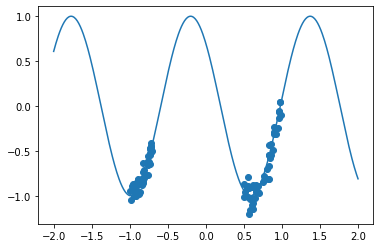

In [9]:
plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

## Bayesian workflow 
The Bayesian workflow can be roughly divided into three parts [Cite critique compute blei]. 
1. Model definition
2. Inference
3. Model Criticism

We expand below on each of these aspects below and explain how TyXe helps us with them. 

### Model Definition 
Defining a model refers to establishing the probability distributions from which the parameters and observed data are drawn. In other words we specify $p(y|x,\theta)p(\theta)$. TyXe requires that we do this by specifying the following objects

1) **Neural network**: This is the function which specifies the way in which $p(y|x,\theta)$ depends on $x$. The parameters of this neural network are what we refered to as $\theta$ above. In TyXe this is encoded as any neural network specified in Pytorch which subclasses the ``nn.Module``class. Due to this flexibility and the large number of classes that exist in Pytorch it is easy for practioners and researchers to apply bayesian methods to a large array of architectures. 
<div class="alert alert-block alert-info">
<b>Advanced:</b> Under the hood, TyXe represent neural networks using the <code>PyroModule</code> abstraction from Pyro as it provides a seameless way for <code> nn.Parameters </code> to be replaced with Pyro sample sites. 
</div>


In [10]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50,1))

2) **Prior**: This defines the probability distribution over the parameters of the neural network. In TyXe they are specified via `tyxe.priors.Prior` object. For this example we assume that every parametr will have the exact same distribution and that they are independent and identically distributed. This is done via `tyxe.priors.IIDPrior` which is used with a one-dimensional pyro distribution which can be extended to the shape of each site of the parameters inside of the neural network. More generally, TyXe also allows for more genral priors including layer wise priors that provide a bayesian equivalent to "Radford", "Xavier" and "Kaming" initializations. 
<div class="alert alert-block alert-info">
<b>Advanced:</b> An important point is that TyXe allows users to excludee certain parameters of the neural network from being treated in a Bayesian way. This can be done by passing a <code> hide_module_types </code> or <code> hide_module</code> argument to the prior. In the case of the former we pass a list of classes inherting from <code> nn.Module </code> (eg. <code>[nn.BatchNorm2D]</code>) and in the case of the former we pass particular <code> nn.Modules </code> objects from our neural net. 
</div>

In [11]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

3) **Likelihood:** Defines the $p(y|x,\theta)$ term by specifying how the output of the neural network is to be used to describe the probability distribution. In TyXe this is done via a `tyxe.likelihoods.Likelihood` object. In our case we will use `tyxe.likelihoods.HomoskedasticGaussian` which implies that the data is modeled as $p(y|x,\theta) = \mathcal{N}(f_\theta(x), \sigma^2)$. In otherwords, the variance is the same regardless of the point that we choose.

An important detail is that all likelihoods require that we specify the size of the dataset that needs to be used in advace via the `dataset_size` argument when constructing the object. This is so that when using minibatches the loss can be scaled adequately. 

Furthermore, in addition to the likelihood used for this particular example TyXe also contains implementations of Categrical distributions, Bernoulli distributions, and distributions where we also model the variance as well as the mean. 





In [14]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)

## Inference
Once we specify our model we need to do inference on it to learn a distribution for the parameters. TyXe implements both variational inference as well MCMC algorithms for doing inference on the neural network. 

### Stochastic Variational Inference 
Stochastic Variational Inference is a process by which we approximate the complex posterior distribution of our parameters by a simpler distribution belonging to a family which is easier to handle. For an in-depth discussion of SVI see [this](https://pyro.ai/examples/svi_part_i.html) tutorial. The family of distributions (usually called in the literature variational family) is specified in TyXe by a `guide`. 

#### Guides in TyXe
Currently TyXe supports as a variational family the distribution where every parameter is sampled independently from a normal distribution via the `tyxe.guides.AutoNormal` object. This object is passed to the constructor of the neural network so that it builds the guide at each of the unobseved sites. The  `partial` function below is simply a way so that every time that a guide is created it is initialized with particular parameters. 


In [15]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

Finally, once all of the above has been done we can instantiate our neural network and train it using the fit method as shown below. This method can take an optional callback function with is invoked after each training epoch as is done below. It takes as arguments the neural network, the epoch and the average value of the Elbo over the specified epoch. 

Something to note as well is the `with` stament for the fit method. This is a strategy implemented under the hood which reduces the the variance of the gradients (see [add reference here for local reparametrization])


In [17]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [18]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    elbos.append(e)
    
with tyxe.poutine.local_reparameterization():
    bnn.fit(loader, optim, 10000, callback)

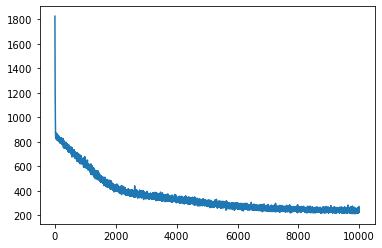

In [9]:
plt.plot(elbos)

In [12]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

(-2.0, 2.0)

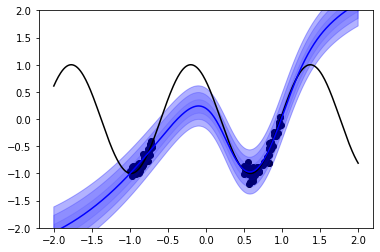

In [20]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

In [12]:
with tyxe.poutine.local_reparameterization():
    m, sd = bnn.predict(x_test, num_predictions=32)

torch.save((x, y, x_test, y_test, m, sd), "ffg_lr_predictions.pt")

(-2.0, 2.0)

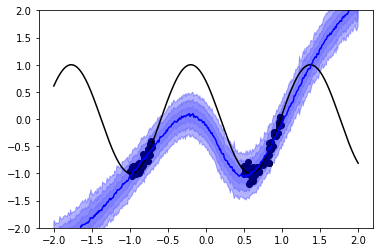

In [13]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

### MCMC
Alternatively, it is possible to do exact inference using Markov Chain Monte Carlo. Here the only thing that is different is that instead of a guide we provide a [kernel](https://docs.pyro.ai/en/stable/mcmc.html) from Pyro i.e a method for drawing samples from the chain. Unfortunately, although the inference is exact in the limit. It is also significantly slower than SVI. A more thorough discussion of MCMC can be found [here](https://arxiv.org/pdf/1701.02434.pdf)

In [21]:
pyro.clear_param_store()
mcmc_net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
mcmc_prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
mcmc_likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=50, target_accept_prob=0.7)
mcmc_bnn = tyxe.bnn.MCMC_BNN(mcmc_net, mcmc_prior, mcmc_likelihood, kernel)

In [23]:
mcmc_bnn.fit(loader, 100000, warmup_steps=20000)

Sample: 100%|██████████| 120000/120000 [07:26, 268.73it/s, step size=2.19e-02, acc. prob=0.957]


## Prediction 
After we have estimated the posterior either through MCMC or SVI we can make predictions on unseen data. This is done through the `.predict` method in the bayesian neural nets. This method takes as input a batch of data and the number of samples from the neural network that we want to use to make the predictions. In the case of a `VariationalBNN` this is done by using the guide as an approximation of the posterior and in the case of the `MCMC_BNN` this is done by using the samples drawn when the `fit` method was called. 

By default the `.predict` method returns an average of all of the samples drawn and the standard deviation. However, it is possible for the network to return all of the samples drawn by calling `predict` with `aggregate=False`.  The

#### Predictions using SVI

In [24]:
m, sd = bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

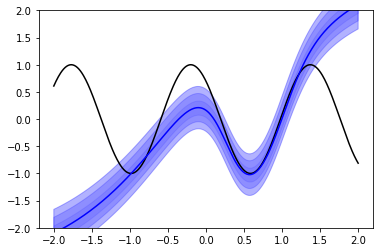

In [25]:
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

#### Predictions using MCMC

In [26]:
m, sd = mcmc_bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

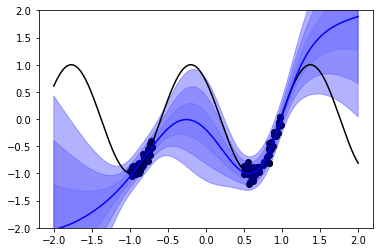

In [27]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 4):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

(-2.0, 2.0)

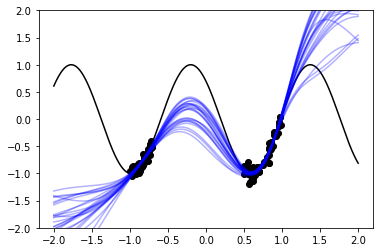

In [18]:
sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)
plt.ylim(-2, 2)

In [19]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(10000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-2.0, 2.0)

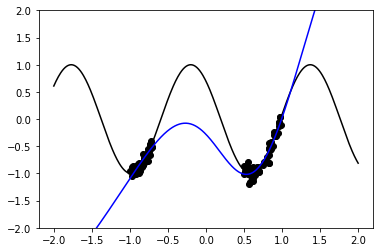

In [20]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
plt.plot(x_test, net(x_test).detach(), color="blue")
plt.ylim(-2, 2)